In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.stats import binom

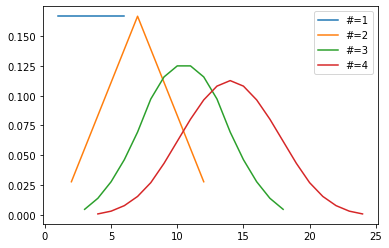

In [94]:
# N 6-sided dice added distribution
# complexity O(6**N), not very efficient | I am sure there is analytical formula for this

die = [1, 2, 3, 4, 5, 6]
for n in range(1, 5):
    dice = product(die, repeat=n)
    freq = pd.DataFrame(dice).sum(1).value_counts().sort_index()
    prob = freq / freq.sum()

    prob.plot(label=f'#={n}')

plt.legend()

In 2015 I read a paper that tested whether people diagnosed with gluten sensitivity (but not celiac disease) were able to distinguish gluten flour from non-gluten flour in a blind challenge (you can read the paper here).

Out of 35 subjects, 12 correctly identified the gluten flour based on resumption of symptoms while they were eating it. Another 17 wrongly identified the gluten-free flour based on their symptoms, and 6 were unable to distinguish.

The authors conclude, “Double-blind gluten challenge induces symptom recurrence in just one-third of patients.”

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance. So here’s the question: based on this data, how many of the subjects are sensitive to gluten and how many are guessing?

We can use Bayes’s Theorem to answer this question, but first we have to make some modeling decisions. I’ll assume:

People who are sensitive to gluten have a 95% chance of correctly identifying gluten flour under the challenge conditions, and

People who are not sensitive have a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).

Text(0.5, 1.0, 'P[# of True Gluten Sensitive | Data]')

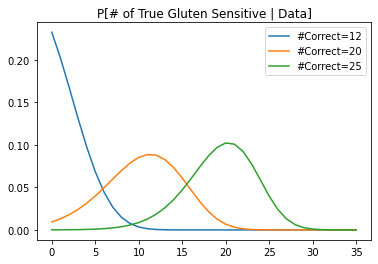

In [280]:
pGS, pNGS = 0.95, 0.4
N = 35

def construct_likelihood(nGS, nNGS):
    pmfGS = pd.Series(binom.pmf(k=range(nGS+1), n=nGS, p=pGS), index=range(nGS+1))  # number of sensitive
    pmfNGS = pd.Series(binom.pmf(k=range(nNGS+1), n=nNGS, p=pNGS), index=range(nNGS+1))  # number of not sensitive

    res = {}
    for a, b in product(pmfGS.index, pmfNGS.index):  # convolve two binom dist
        q = a + b
        p = pmfGS[a] * pmfNGS[b]
        res[q] = res.get(q, 0) + p

    pmfALL = pd.Series(res).sort_index()
    return pmfALL

for y in [12, 20, 25]:
    likelihood = {}
    for n in range(0, 35+1):
        likelihood[n] = construct_likelihood(n, N-n).loc[y]
    likelihood = pd.Series(likelihood).sort_index()

    prior = np.ones(likelihood.size) / likelihood.size  # uniform prior
    posterior = prior * likelihood
    posterior /= posterior.sum()

    posterior.plot(label=f'#Correct={y}')

plt.legend()
plt.title("P[# of True Gluten Sensitive | Data]")

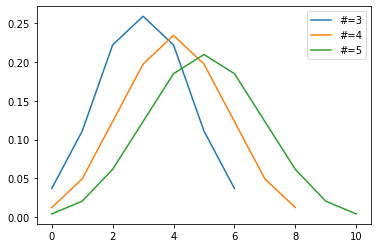

In [398]:
"""
Betrayal at House on the Hill is a strategy game in which characters with different attributes explore a haunted house.
Depending on their attributes, the characters roll different numbers of dice.
For example, if attempting a task that depends on knowledge,
Professor Longfellow rolls 5 dice, Madame Zostra rolls 4, and Ox Bellows rolls 3. Each die yields 0, 1, or 2 with equal probability.

If a randomly chosen character attempts a task three times and rolls a total of 3 on the first attempt, 4 on the second, and 5 on the third, which character do you think it was?
"""
die = [0, 1, 2]
role = {}
for n in range(3, 6):
    dice = product(die, repeat=n)
    freq = pd.DataFrame(dice).sum(1).value_counts().sort_index()
    prob = freq / freq.sum()
    role[n] = prob
    prob.plot(label=f'#={n}')

plt.legend()

array([0.31453402, 0.44970414, 0.23576183])

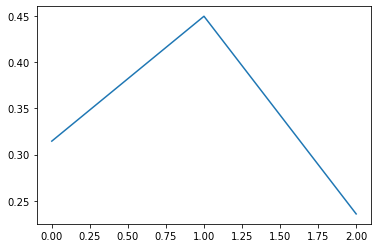

In [403]:
prior = np.ones(3) / 3  # 3, 4, 5 number of dice
posterior = prior.copy()
for n in [3, 4, 5]:
    likelihood = np.array([role[3].loc[n], role[4].loc[n], role[5].loc[n]])
    posterior *= likelihood
posterior /= posterior.sum()

plt.plot(posterior)
posterior

Text(0.5, 0, '# of honest')

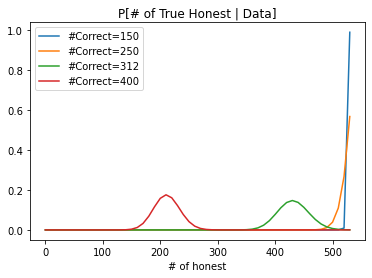

In [438]:
"""
There are 538 members of the United States Congress.
Suppose we audit their investment portfolios and find that 312 of them out-perform the market.
Let’s assume that an honest member of Congress has only a 50% chance of out-performing the market,
but a dishonest member who trades on inside information has a 90% chance.
How many members of Congress are honest?
"""
pH, pNH = 0.5, 0.9
N = 538

def construct_likelihood(nH, nNH):
    pmfH = pd.Series(binom.pmf(k=range(nH+1), n=nH, p=pH), index=range(nH+1))  # number of honest
    pmfNH = pd.Series(binom.pmf(k=range(nNH+1), n=nNH, p=pNH), index=range(nNH+1))  # number of not honest

    res = {}
    for a, b in product(pmfH.index, pmfNH.index):  # convolve two binom dist
        q = a + b
        p = pmfH[a] * pmfNH[b]
        res[q] = res.get(q, 0) + p

    pmfALL = pd.Series(res).sort_index()
    return pmfALL

for y in [150, 250, 312, 400]:  # number of OP
    likelihood = {}
    for n in range(0, N+1, 10):
        likelihood[n] = construct_likelihood(n, N-n).loc[y]
    likelihood = pd.Series(likelihood).sort_index()

    prior = np.ones(likelihood.size) / likelihood.size  # uniform prior
    posterior = prior * likelihood
    posterior /= posterior.sum()

    posterior.plot(label=f'#Correct={y}')

plt.legend()
plt.title("P[# of True Honest | Data]")
plt.xlabel('# of honest')